In [75]:
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

import torch

from importlib import reload

import clustering
import model
import train
import utils.data

reload(clustering)
reload(utils.data)
reload(model)
reload(train)

from clustering import get_cluster_centers, cosine_dist
from model import FFN
from train import train
from utils.data import load_data_from_tsv

In [85]:
ffn = FFN(128, 16, 4, 32)
ffn.load_state_dict(torch.load("checkpoints/checkpoint_128_16_4_32_epoch=199_batch-size=8.cpkt"))

<All keys matched successfully>

In [86]:
train_df = load_data_from_tsv("dataset/train.tsv")
cluster_centers = get_cluster_centers(train_df, ffn)

In [87]:
test_df = load_data_from_tsv("dataset/test.tsv")
test_embeddings = ffn(torch.stack(list(test_df["hist"])))

good = 0
for name, embedding in zip(test_df["obj_name"], test_embeddings):
    items = list(cluster_centers.items())
    keys = [key for key, _ in items]
    dists = [float(cosine_dist(embedding, value)) for _, value in items]
    cluster_name = keys[np.argmin(dists)]
    print(f"{name} vs {cluster_name}")
    good += (name == cluster_name)
    
print(f"accuracy={good / len(test_df)}")
        

Torus vs Torus
Torus vs Cube
Cone vs Cube
Cube vs Cube
Cone vs Cube
Sphere vs Sphere
Cube vs Cube
Cone vs Sphere
Cylinder vs Cube
Cube vs Cube
Cylinder vs Torus
Cube vs Cube
Cone vs Torus
Sphere vs Sphere
Cylinder vs Cube
Cylinder vs Torus
Torus vs Sphere
Cone vs Torus
Sphere vs Sphere
Cube vs Cube
Torus vs Torus
Cube vs Cube
Cone vs Cube
Cube vs Cube
Cube vs Cube
Torus vs Cube
Torus vs Cube
Cylinder vs Cube
Torus vs Cube
Cone vs Sphere
Torus vs Sphere
Cone vs Cylinder
Torus vs Sphere
Torus vs Sphere
Sphere vs Cube
Sphere vs Cube
Cube vs Cube
Cube vs Cone
Sphere vs Sphere
Cylinder vs Cube
Cube vs Cube
Sphere vs Sphere
Cylinder vs Cube
Torus vs Cube
Cone vs Cube
Cone vs Cube
Cone vs Cube
Cube vs Cube
Cone vs Torus
Cone vs Cube
accuracy=0.36


In [88]:
test_embeddings_np = test_embeddings.detach().numpy()

pca = PCA(n_components=2)
pca.fit(test_embeddings_np)

test_projections = test_embeddings_np @ pca.components_.T

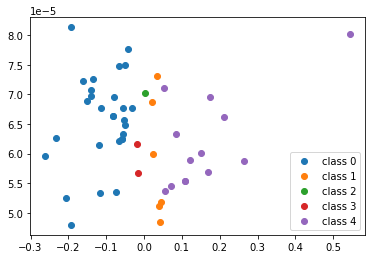

In [89]:
n_classes = 5
aclust = AgglomerativeClustering(n_clusters=n_classes, affinity='cosine', linkage='complete')
aclust.fit(test_embeddings_np)

classes = [[] for i in range(n_classes)]

for i in range(len(test_df)):
    classes[aclust.labels_[i]].append(test_projections[i])

for class_ in classes:
    class_ = np.array(class_)
    plt.scatter(class_[:, 0], class_[:, 1])

plt.legend([f"class {j}" for j in range(n_classes)])

In [90]:
queries_classes = [[] for i in range(n_classes)]
for i, query in enumerate(test_df["obj_name"]):
    queries_classes[aclust.labels_[i]].append(query)

for i, queries_class in enumerate(queries_classes):
    print(f"Class #{i}")
    for query in queries_class:
        print(query)
    print()

Class #0
Torus
Cone
Cube
Cone
Cube
Cylinder
Cube
Cube
Cylinder
Cube
Cube
Cone
Cube
Cube
Torus
Torus
Cylinder
Torus
Sphere
Sphere
Cube
Cylinder
Cube
Torus
Cone
Cone
Cube
Cone

Class #1
Torus
Cylinder
Cone
Cone
Torus
Cone

Class #2
Cube

Class #3
Cylinder
Cone

Class #4
Sphere
Cone
Sphere
Cylinder
Torus
Sphere
Cone
Torus
Torus
Torus
Sphere
Sphere
Cone

